# Project 3: Airbnb
**This is the third of three mandatory projects to be handed in as part of the assessment for the course 02807 Computational Tools for Data Science at Technical University of Denmark, autumn 2019.**

#### Practical info
- **The project is to be done in groups of at most 3 students**
- **Each group has to hand in _one_ Jupyter notebook (this notebook) with their solution**
- **The hand-in of the notebook is due 2019-12-05, 23:59 on DTU Inside**

#### Your solution
- **Your solution should be in Python/PySpark**
- **For each question you may use as many cells for your solution as you like**
- **You should not remove the problem statements**
- **Your notebook should be runnable, i.e., clicking [>>] in Jupyter should generate the result that you want to be assessed**
- **You are not expected to use machine learning to solve any of the exercises**

# Introduction
[Airbnb](http://airbnb.com) is an online marketplace for arranging or offering lodgings. In this project you will use Spark to analyze data obtained from the Airbnb website. The purpose of the analysis is to extract information about trends and patterns from the data.

The project has two parts.

### Part 1: Loading, describing and preparing the data
There's quite a lot of data. Make sure that you can load and correctly parse the data, and that you understand what the dataset contains. You should also prepare the data for the analysis in part two. This means cleaning it and staging it so that subsequent queries are fast.

### Par 2: Analysis
In this part your goal is to learn about trends and usage patterns from the data. You should give solutions to the tasks defined in this notebook, and you should use Spark to do the data processing. You may use other libraries like for instance Pandas and matplotlib for visualisation.

## Guidelines
- Processing data should be done using Spark. Once data has been reduced to aggregate form, you may use collect to extract it into Python for visualisation.
- Your solutions will be evaluated by correctness, code quality and interpretability of the output. This means that you have to write clean and efficient Spark code that will generate sensible execution plans, and that the tables and visualisations that you produce are meaningful and easy to read.
- You may add more cells for your solutions, but you should not modify the notebook otherwise.

## Reference websites
http://nadbordrozd.github.io/blog/2016/05/22/one-weird-trick-that-will-fix-your-pyspark-schemas/


### Create Spark session and define imports

In [1]:
from pyspark import SparkContext #https://www.tutorialspoint.com/pyspark/pyspark_sparkcontext.htm
from pyspark.sql import SQLContext

try:
    SparkContext.stop(sc)
except:
    pass
SparkContext.setSystemProperty('spark.executor.memory', '4g')
SparkContext.setSystemProperty('spark.executor.instances', '4')

sc = SparkContext("local", "SparkProject3") #spark context https://www.tutorialspoint.com/pyspark/pyspark_sparkcontext.htm
sqlContext = SQLContext(sc)


In [2]:
from pyspark.sql import *
from pyspark.sql import functions as f
from pyspark.sql.types import *
from pyspark.conf import SparkConf

spark = SparkSession.builder.appName("SparkProject3").getOrCreate()

spark = SparkSession.builder \
        .master("local") \
        .appName("SparkProject3") \
        .config("spark.some.config.option", "some-value") \
        .getOrCreate()

## Functions

In [3]:
import pyspark.sql.types as pst
from pyspark.sql import Row

def infer_schema(rec):
    """infers dataframe schema for a record. Assumes every dict is a Struct, not a Map"""
    if isinstance(rec, dict):
        return pst.StructType([pst.StructField(key, infer_schema(value), True)
                              for key, value in sorted(rec.items())])
    elif isinstance(rec, list):
        if len(rec) == 0:
            raise ValueError("can't infer type of an empty list")
        elem_type = infer_schema(rec[0])
        for elem in rec:
            this_type = infer_schema(elem)
            if elem_type != this_type:
                raise ValueError("can't infer type of a list with inconsistent elem types")
        return pst.ArrayType(elem_type)
    else:
        return pst._infer_type(rec)

In [4]:
def _rowify(x, prototype):
    """creates a Row object conforming to a schema as specified by a dict"""

    def _equivalent_types(x, y):
        if type(x) in [str, unicode] and type(y) in [str, unicode]:
            return True
        return isinstance(x, type(y)) or isinstance(y, type(x))

    if x is None:
        return None
    elif isinstance(prototype, dict):
        if type(x) != dict:
            raise ValueError("expected dict, got %s instead" % type(x))
        rowified_dict = {}
        for key, val in x.items():
            if key not in prototype:
                raise ValueError("got unexpected field %s" % key)
            rowified_dict[key] = _rowify(val, prototype[key])
            for key in prototype:
                if key not in x:
                    raise ValueError(
                        "expected %s field but didn't find it" % key)
        return Row(**rowified_dict)
    elif isinstance(prototype, list):
        if type(x) != list:
            raise ValueError("expected list, got %s instead" % type(x))
        return [_rowify(e, prototype[0]) for e in x]
    else:
        if not _equivalent_types(x, prototype):
            raise ValueError("expected %s, got %s instead" %
                             (type(prototype), type(x)))
        return x

In [5]:
def df_from_rdd(rdd, prototype, sql):
    """creates a dataframe out of an rdd of dicts, with schema inferred from a prototype record"""
    schema = infer_schema(prototype)
    row_rdd = rdd.map(lambda x: _rowify(x, prototype))
    return sql.createDataFrame(row_rdd, schema)

df = df_from_rdd(rdd, prototype, sqlContext)

In [7]:
def read(path,f):
    return spark.read.option('inferSchema', True).option('multiline', True).csv(path+f, escape='"', header=True)

def read_parquet(path,f):
    return spark.read.parquet(path+f)

In [8]:
def disp(x, n):
    """ Prettier spark dataframe printing with pandas
        Args:
            x: dataframe
            n: number of rows to display
    """
    return x.limit(n).toPandas().head(n)

# Part 1: Loading, describing and preparing the data
The data comes in two files. Start by downloading the files and putting them in your `data/` folder.

- [Listings](https://files.dtu.dk/u/siPzAasj8w2gI_ME/listings.csv?l) (5 GB)
- [Reviews](https://files.dtu.dk/u/k3oaPYp6GjKBeho4/reviews.csv?l) (9.5 GB)

### Load the data
The data has multiline rows (rows that span multiple lines in the file). To correctly parse these you should use the `multiline` option and set the `escape` character to be `"`.

In [9]:
!ls

 1232cb984c9e
 1d8d2e302cd5
 4c8a18b509eb
 6193ebff96e2
 6cd8b62f0451
 8e04e5fe98a6
 989f3b2baa52
 a53524a96747
 a674c35b66a1
 a7aedc881f2b
 arita_Project3_v2_0.ipynb
 data
 f495661be4ae
'Mandatory Assignment 1 - Counting Words.ipynb'
'Mandatory Assignment 2 - Sampling Customers.ipynb'
'MySQL connection example.ipynb'
'Project 1 - Customer Database.ipynb'
'Project 2 - Web Traffic Analysis.ipynb'
'Project 3 - Airbnb.ipynb'
'SQLite connection example.ipynb'
 traffic_2_sample.tsv
 Using
'Week 10 - Introduction to Spark.ipynb'
 week10.md
'Week 10 - Spark UI Demo.ipynb'
'Week 11 - Advanced Spark functions.ipynb'
'Week 2 - Heart Disease Data Analysis.ipynb'
'Week 2 - Python Highlights.ipynb'
'Week 3 - Chuck Norris.ipynb'
'Week 3 - Training a model using scikit-learn.ipynb'
'Week 4 - Join exercises.ipynb'


In [10]:
root = 'data/'
f1 = 'listings.parquet'
path1 ='data/listings.csv'
f2 ='reviews.parquet'
path2 ='data/reviews.csv'
delimiters = "," 

### First attempt...takes long to load the entire file 

In [63]:

path1 ='data/listings.csv'
#path1 = 'https://files.dtu.dk/u/siPzAasj8w2gI_ME/listings.csv?l'
df_listing = spark.read.option('inferSchema', True) \
                .option("delimiter", delimiters)\
                .option('multiLine', True).csv(path1, escape = '"',header= True)#.limit(50)

In [12]:
path2 ='data/reviews.csv'
df_reviews = spark.read.option('inferSchema', True) \
                .option("delimiter", delimiters)\
                .option('multiLine', True).csv(path2, escape = '"',header= True)#.limit(50)

#spark.read.option('header', True).option('header', True).option("escape", '"').option('multiLine', True).csv(path2)

### using parquet? - Zachs code returns me error

listings = read_parquet(path1,f1)

reviews = read_parquet(path2)

A possible alternative would be chunking in smaller portions...

def arichuck ():
    chunksize 10**6
    for chunk in spark.read(filename, chunksize):
        process (chunk)

or try to load only a limited amount of lines:

### Describe the data
List the features (schema) and sizes of the datasets.

df_listing.show() #<--------------- veeeery shitty

In [13]:
df_listing.limit(10).toPandas().head()

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,...,instant_bookable,is_business_travel_ready,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,145320,https://www.airbnb.com/rooms/145320,20190928160308,2019-09-28,In the middle of it all - with a view!,"Mitt boende passar par, kompisar och ensamäven...",A cozy three room flat with great personality....,"Mitt boende passar par, kompisar och ensamäven...",none,"The flat is in the area of Södermalm, the youn...",...,t,f,strict_14_with_grace_period,f,f,1,0,1,0,2.54
1,155220,https://www.airbnb.com/rooms/155220,20190928160308,2019-09-28,"Stockholm, new spacoius villa",Convenient and spacy home full of positive ene...,ABOUT THE HOUSE: Modern villa built in 2010. L...,ABOUT THE HOUSE: Modern villa built in 2010. L...,none,Close to nature and easy access to citylife.,...,f,f,moderate,f,f,2,2,0,0,None
2,155685,https://www.airbnb.com/rooms/155685,20190928160308,2019-09-28,Hornstull with water view!,This apartment is located in the center of fun...,"46 sqm apartment in Hornstulls, Södermalm Stoc...",This apartment is located in the center of fun...,none,There is a funky vibe here!,...,f,f,moderate,f,f,1,1,0,0,0.22
3,164448,https://www.airbnb.com/rooms/164448,20190928160308,2019-09-28,Double room in central Stockholm with Wi-Fi,I am renting out a nice double room on the top...,ROOM: The room has a twin/double bed (2x90x200...,I am renting out a nice double room on the top...,none,None,...,t,f,flexible,t,t,2,0,2,0,3.13
4,170651,https://www.airbnb.com/rooms/170651,20190928160308,2019-09-28,Petit Charm Rooftop next to heaven,None,"Welcome to this beautiful, small, and charming...","Welcome to this beautiful, small, and charming...",none,None,...,f,f,strict_14_with_grace_period,f,f,1,1,0,0,0.33


In [73]:
df_listing.printSchema()

root
 |-- id: string (nullable = true)
 |-- listing_url: string (nullable = true)
 |-- scrape_id: string (nullable = true)
 |-- last_scraped: string (nullable = true)
 |-- name: string (nullable = true)
 |-- summary: string (nullable = true)
 |-- space: string (nullable = true)
 |-- description: string (nullable = true)
 |-- experiences_offered: string (nullable = true)
 |-- neighborhood_overview: string (nullable = true)
 |-- notes: string (nullable = true)
 |-- transit: string (nullable = true)
 |-- access: string (nullable = true)
 |-- interaction: string (nullable = true)
 |-- house_rules: string (nullable = true)
 |-- thumbnail_url: string (nullable = true)
 |-- medium_url: string (nullable = true)
 |-- picture_url: string (nullable = true)
 |-- xl_picture_url: string (nullable = true)
 |-- host_id: string (nullable = true)
 |-- host_url: string (nullable = true)
 |-- host_name: string (nullable = true)
 |-- host_since: string (nullable = true)
 |-- host_location: string (nullable

In [14]:
df_listing.count()

1330480

In [15]:
df_reviews.limit(20).show()

+----------+---------+----------+-----------+-------------+--------------------+
|listing_id|       id|      date|reviewer_id|reviewer_name|            comments|
+----------+---------+----------+-----------+-------------+--------------------+
|    145320|156423122|2017-05-30|  123386382|        Erwin|Prima plek om Sto...|
|    145320|170211906|2017-07-15|  123091743|         Anne|Cosy and clean fl...|
|    145320|172169175|2017-07-20|      78004|     Patricia|The host canceled...|
|    145320|176647581|2017-07-31|  103178743|    Charlotte|Kim's place was o...|
|    145320|185676021|2017-08-22|    4023961|    Alexander|great spacious ap...|
|    145320|189668224|2017-09-02|  142869362|        Heiko|Kim is a very fri...|
|    145320|191894030|2017-09-09|   25194419|        Jason|The apartment is ...|
|    145320|193316070|2017-09-13|   52056015|        David|Nicely appointed,...|
|    145320|196760607|2017-09-24|    3980456|        Janne|It was a pleasure...|
|    145320|201885633|2017-1

In [16]:
df_reviews.printSchema()

root
 |-- listing_id: string (nullable = true)
 |-- id: string (nullable = true)
 |-- date: string (nullable = true)
 |-- reviewer_id: string (nullable = true)
 |-- reviewer_name: string (nullable = true)
 |-- comments: string (nullable = true)



df_reviews.count() # heavy

df = df_listing.join(df_reviews, ['ColumnNameInCommon'], 'inner')

ldf.printSchema()

### Prepare the data for analysis
You should prepare two dataframes to be used in the analysis part of the project. You should not be concerned with cleaning the data. There's a lot of it, so it will be sufficient to drop rows that have bad values. You may want to go back and refine this step at a later point when doing the analysis.

You may also want to consider if you can stage your data so that subsequent processing is more efficient (this is not strictly necessary for Spark to run, but you may be able to decrease the time you sit around waiting for Spark to finish things)

## 1- keeping necessary columns from listing_df

We decide to keep less columns: 

 |-- id: string (nullable = true)
 
 |-- summary: string (nullable = true)
 
 |-- description: string (nullable = true)
 
 |-- property_type: string (nullable = true)
 
 |-- neighbourhood: string (nullable = true)
 
 |-- neighbourhood_group_cleansed: string (nullable = true)
 
 |-- city: string (nullable = true)
 
 |-- zipcode: string (nullable = true)
 
 |-- country_code: string (nullable = true)
 
 |-- country: string (nullable = true)
 
 |-- price: string (nullable = true)
 
 |-- review_scores_rating: string (nullable = true)
 
 |-- reviews_per_month: string (nullable = true)

### selecting columns

In [64]:
df_listing_clean = df_listing.select([c for c in df_listing.columns if c in ['id','summary','description','property_type','neighbourhood','neighbourhood_group_cleansed','city','zipcode','country_code','country','price','review_scores_rating','reviews_per_month']])

In [65]:
df_listing_clean .limit(10).toPandas().head()

,id,summary,description,neighbourhood,neighbourhood_group_cleansed,city,zipcode,country_code,country,property_type,price,review_scores_rating,reviews_per_month
0,145320,"Mitt boende passar par, kompisar och ensamäven...","Mitt boende passar par, kompisar och ensamäven...",Södermalm,None,Stockholm,118 53,SE,Sweden,Apartment,"$1,272.00",97,2.54
1,155220,Convenient and spacy home full of positive ene...,ABOUT THE HOUSE: Modern villa built in 2010. L...,Skarpnäck,None,Stockholm,None,SE,Sweden,House,"$1,203.00",None,None
2,155685,This apartment is located in the center of fun...,This apartment is located in the center of fun...,Södermalm,None,Stockholm,11739,SE,Sweden,Apartment,"$3,209.00",94,0.22
3,164448,I am renting out a nice double room on the top...,I am renting out a nice double room on the top...,Södermalm,None,Stockholm,11864,SE,Sweden,Apartment,$597.00,97,3.13
4,170651,None,"Welcome to this beautiful, small, and charming...",Södermalm,None,Stockholm,11737,SE,Sweden,Apartment,$734.00,93,0.33


## dropping columns

In [66]:
columns_to_drop = ['neighbourhood_group_cleansed','zipcode','country_code']
df_listing_clean  = df_listing_clean .drop(*columns_to_drop)

In [67]:
df_listing_clean .limit(10).toPandas()

,id,summary,description,neighbourhood,city,country,property_type,price,review_scores_rating,reviews_per_month
0,145320,"Mitt boende passar par, kompisar och ensamäven...","Mitt boende passar par, kompisar och ensamäven...",Södermalm,Stockholm,Sweden,Apartment,"$1,272.00",97,2.54
1,155220,Convenient and spacy home full of positive ene...,ABOUT THE HOUSE: Modern villa built in 2010. L...,Skarpnäck,Stockholm,Sweden,House,"$1,203.00",None,None
2,155685,This apartment is located in the center of fun...,This apartment is located in the center of fun...,Södermalm,Stockholm,Sweden,Apartment,"$3,209.00",94,0.22
3,164448,I am renting out a nice double room on the top...,I am renting out a nice double room on the top...,Södermalm,Stockholm,Sweden,Apartment,$597.00,97,3.13
4,170651,None,"Welcome to this beautiful, small, and charming...",Södermalm,Stockholm,Sweden,Apartment,$734.00,93,0.33
5,206221,None,The region is situated at one of Stockholms mo...,Södermalm,Stockholm,Sweden,Bed and breakfast,$665.00,98,0.82
6,220233,"My apartment is located in Vasastan, a beautif...","My apartment is located in Vasastan, a beautif...",Norrmalm,Stockholm,Sweden,Apartment,$890.00,None,None
7,220851,Welcome!,"Welcome! Welcome! One big bedroom ,quiet and c...",Kungsholmen,Stockholm,Sweden,Apartment,$597.00,93,0.46
8,242188,I am renting out a nice single room on the top...,I am renting out a nice single room on the top...,Södermalm,Stockholm,Sweden,Apartment,$558.00,97,3.19
9,259025,None,If I describe how we live. You are welcome t...,Rinkeby-Kista,Stockholm,Sweden,Townhouse,$196.00,89,0.63


## 2-drop the rows containing any null or NaN values

to be don, but i will come back to this later

df_listing_clean  = df_listing_clean .na.drop()

df_listing_clean .limit(10).toPandas().head()

df_listing.count()

df = df.na().drop()

drop rows in "ColumnName"

ColumnName = ""

df.na.drop([ColumnName])

df.filter(df.col(ColumnName).isNotNull())

In [147]:
df_listing_clean.write.partitionBy('property_type').csv(root+'df_listing.csv')

Py4JJavaError: An error occurred while calling o1834.csv.
: org.apache.spark.SparkException: Job aborted.
	at org.apache.spark.sql.execution.datasources.FileFormatWriter$.write(FileFormatWriter.scala:198)
	at org.apache.spark.sql.execution.datasources.InsertIntoHadoopFsRelationCommand.run(InsertIntoHadoopFsRelationCommand.scala:159)
	at org.apache.spark.sql.execution.command.DataWritingCommandExec.sideEffectResult$lzycompute(commands.scala:104)
	at org.apache.spark.sql.execution.command.DataWritingCommandExec.sideEffectResult(commands.scala:102)
	at org.apache.spark.sql.execution.command.DataWritingCommandExec.doExecute(commands.scala:122)
	at org.apache.spark.sql.execution.SparkPlan$$anonfun$execute$1.apply(SparkPlan.scala:131)
	at org.apache.spark.sql.execution.SparkPlan$$anonfun$execute$1.apply(SparkPlan.scala:127)
	at org.apache.spark.sql.execution.SparkPlan$$anonfun$executeQuery$1.apply(SparkPlan.scala:155)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.sql.execution.SparkPlan.executeQuery(SparkPlan.scala:152)
	at org.apache.spark.sql.execution.SparkPlan.execute(SparkPlan.scala:127)
	at org.apache.spark.sql.execution.QueryExecution.toRdd$lzycompute(QueryExecution.scala:80)
	at org.apache.spark.sql.execution.QueryExecution.toRdd(QueryExecution.scala:80)
	at org.apache.spark.sql.DataFrameWriter$$anonfun$runCommand$1.apply(DataFrameWriter.scala:676)
	at org.apache.spark.sql.DataFrameWriter$$anonfun$runCommand$1.apply(DataFrameWriter.scala:676)
	at org.apache.spark.sql.execution.SQLExecution$$anonfun$withNewExecutionId$1.apply(SQLExecution.scala:78)
	at org.apache.spark.sql.execution.SQLExecution$.withSQLConfPropagated(SQLExecution.scala:125)
	at org.apache.spark.sql.execution.SQLExecution$.withNewExecutionId(SQLExecution.scala:73)
	at org.apache.spark.sql.DataFrameWriter.runCommand(DataFrameWriter.scala:676)
	at org.apache.spark.sql.DataFrameWriter.saveToV1Source(DataFrameWriter.scala:285)
	at org.apache.spark.sql.DataFrameWriter.save(DataFrameWriter.scala:271)
	at org.apache.spark.sql.DataFrameWriter.save(DataFrameWriter.scala:229)
	at org.apache.spark.sql.DataFrameWriter.csv(DataFrameWriter.scala:664)
	at sun.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at sun.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:62)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:498)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:357)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.GatewayConnection.run(GatewayConnection.java:238)
	at java.lang.Thread.run(Thread.java:748)
Caused by: org.apache.spark.SparkException: Job aborted due to stage failure: Task 0 in stage 231.0 failed 1 times, most recent failure: Lost task 0.0 in stage 231.0 (TID 4181, localhost, executor driver): org.apache.spark.SparkException: Task failed while writing rows.
	at org.apache.spark.sql.execution.datasources.FileFormatWriter$.org$apache$spark$sql$execution$datasources$FileFormatWriter$$executeTask(FileFormatWriter.scala:257)
	at org.apache.spark.sql.execution.datasources.FileFormatWriter$$anonfun$write$1.apply(FileFormatWriter.scala:170)
	at org.apache.spark.sql.execution.datasources.FileFormatWriter$$anonfun$write$1.apply(FileFormatWriter.scala:169)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:90)
	at org.apache.spark.scheduler.Task.run(Task.scala:123)
	at org.apache.spark.executor.Executor$TaskRunner$$anonfun$10.apply(Executor.scala:408)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:1360)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:414)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1149)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:624)
	at java.lang.Thread.run(Thread.java:748)
Caused by: java.io.IOException: Mkdirs failed to create file:/home/jovyan/work/data/df_listing.csv/_temporary/0/_temporary/attempt_20191127154625_0231_m_000000_4181/property_type=%7BTV,Wifi,%22Air conditioning%22,Elevator,Heating,%22Suitable for events%22,Washer,%22First aid kit%22,%22Fire extinguisher%22,Essentials,Shampoo,Hangers,%22Hair dryer%22,Iron,%22Hot water%22,%22Bed linens%22,%22Ethernet connection%22,Microwave,%22Coffee maker%22,Refrigerator,Dishwasher,%22Dishes and silverware%22} (exists=false, cwd=file:/home/jovyan/work)
	at org.apache.hadoop.fs.ChecksumFileSystem.create(ChecksumFileSystem.java:455)
	at org.apache.hadoop.fs.ChecksumFileSystem.create(ChecksumFileSystem.java:440)
	at org.apache.hadoop.fs.FileSystem.create(FileSystem.java:911)
	at org.apache.hadoop.fs.FileSystem.create(FileSystem.java:892)
	at org.apache.hadoop.fs.FileSystem.create(FileSystem.java:789)
	at org.apache.spark.sql.execution.datasources.CodecStreams$.createOutputStream(CodecStreams.scala:81)
	at org.apache.spark.sql.execution.datasources.CodecStreams$.createOutputStreamWriter(CodecStreams.scala:92)
	at org.apache.spark.sql.execution.datasources.csv.CsvOutputWriter.<init>(CSVFileFormat.scala:177)
	at org.apache.spark.sql.execution.datasources.csv.CSVFileFormat$$anon$1.newInstance(CSVFileFormat.scala:85)
	at org.apache.spark.sql.execution.datasources.DynamicPartitionDataWriter.newOutputWriter(FileFormatDataWriter.scala:236)
	at org.apache.spark.sql.execution.datasources.DynamicPartitionDataWriter.write(FileFormatDataWriter.scala:260)
	at org.apache.spark.sql.execution.datasources.FileFormatWriter$$anonfun$org$apache$spark$sql$execution$datasources$FileFormatWriter$$executeTask$3.apply(FileFormatWriter.scala:245)
	at org.apache.spark.sql.execution.datasources.FileFormatWriter$$anonfun$org$apache$spark$sql$execution$datasources$FileFormatWriter$$executeTask$3.apply(FileFormatWriter.scala:242)
	at org.apache.spark.util.Utils$.tryWithSafeFinallyAndFailureCallbacks(Utils.scala:1394)
	at org.apache.spark.sql.execution.datasources.FileFormatWriter$.org$apache$spark$sql$execution$datasources$FileFormatWriter$$executeTask(FileFormatWriter.scala:248)
	... 10 more

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.org$apache$spark$scheduler$DAGScheduler$$failJobAndIndependentStages(DAGScheduler.scala:1889)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$abortStage$1.apply(DAGScheduler.scala:1877)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$abortStage$1.apply(DAGScheduler.scala:1876)
	at scala.collection.mutable.ResizableArray$class.foreach(ResizableArray.scala:59)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:48)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:1876)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$handleTaskSetFailed$1.apply(DAGScheduler.scala:926)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$handleTaskSetFailed$1.apply(DAGScheduler.scala:926)
	at scala.Option.foreach(Option.scala:257)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:926)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:2110)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2059)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2048)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.runJob(DAGScheduler.scala:737)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2061)
	at org.apache.spark.sql.execution.datasources.FileFormatWriter$.write(FileFormatWriter.scala:167)
	... 33 more
Caused by: org.apache.spark.SparkException: Task failed while writing rows.
	at org.apache.spark.sql.execution.datasources.FileFormatWriter$.org$apache$spark$sql$execution$datasources$FileFormatWriter$$executeTask(FileFormatWriter.scala:257)
	at org.apache.spark.sql.execution.datasources.FileFormatWriter$$anonfun$write$1.apply(FileFormatWriter.scala:170)
	at org.apache.spark.sql.execution.datasources.FileFormatWriter$$anonfun$write$1.apply(FileFormatWriter.scala:169)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:90)
	at org.apache.spark.scheduler.Task.run(Task.scala:123)
	at org.apache.spark.executor.Executor$TaskRunner$$anonfun$10.apply(Executor.scala:408)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:1360)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:414)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1149)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:624)
	... 1 more
Caused by: java.io.IOException: Mkdirs failed to create file:/home/jovyan/work/data/df_listing.csv/_temporary/0/_temporary/attempt_20191127154625_0231_m_000000_4181/property_type=%7BTV,Wifi,%22Air conditioning%22,Elevator,Heating,%22Suitable for events%22,Washer,%22First aid kit%22,%22Fire extinguisher%22,Essentials,Shampoo,Hangers,%22Hair dryer%22,Iron,%22Hot water%22,%22Bed linens%22,%22Ethernet connection%22,Microwave,%22Coffee maker%22,Refrigerator,Dishwasher,%22Dishes and silverware%22} (exists=false, cwd=file:/home/jovyan/work)
	at org.apache.hadoop.fs.ChecksumFileSystem.create(ChecksumFileSystem.java:455)
	at org.apache.hadoop.fs.ChecksumFileSystem.create(ChecksumFileSystem.java:440)
	at org.apache.hadoop.fs.FileSystem.create(FileSystem.java:911)
	at org.apache.hadoop.fs.FileSystem.create(FileSystem.java:892)
	at org.apache.hadoop.fs.FileSystem.create(FileSystem.java:789)
	at org.apache.spark.sql.execution.datasources.CodecStreams$.createOutputStream(CodecStreams.scala:81)
	at org.apache.spark.sql.execution.datasources.CodecStreams$.createOutputStreamWriter(CodecStreams.scala:92)
	at org.apache.spark.sql.execution.datasources.csv.CsvOutputWriter.<init>(CSVFileFormat.scala:177)
	at org.apache.spark.sql.execution.datasources.csv.CSVFileFormat$$anon$1.newInstance(CSVFileFormat.scala:85)
	at org.apache.spark.sql.execution.datasources.DynamicPartitionDataWriter.newOutputWriter(FileFormatDataWriter.scala:236)
	at org.apache.spark.sql.execution.datasources.DynamicPartitionDataWriter.write(FileFormatDataWriter.scala:260)
	at org.apache.spark.sql.execution.datasources.FileFormatWriter$$anonfun$org$apache$spark$sql$execution$datasources$FileFormatWriter$$executeTask$3.apply(FileFormatWriter.scala:245)
	at org.apache.spark.sql.execution.datasources.FileFormatWriter$$anonfun$org$apache$spark$sql$execution$datasources$FileFormatWriter$$executeTask$3.apply(FileFormatWriter.scala:242)
	at org.apache.spark.util.Utils$.tryWithSafeFinallyAndFailureCallbacks(Utils.scala:1394)
	at org.apache.spark.sql.execution.datasources.FileFormatWriter$.org$apache$spark$sql$execution$datasources$FileFormatWriter$$executeTask(FileFormatWriter.scala:248)
	... 10 more


In [ ]:
mycity_review_clean.write.partitionBy('property_type').csv(root+'df_mycity_review.csv')

# Part 2: Analysis
Use Spark and your favorite tool for data visualization to solve the following tasks.

## The basics
Compute and show a dataframe with the number of listings and neighbourhoods per city.

In [68]:
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd

In [69]:
df = df_listing_clean.groupBy('city')\
        .agg(f.countDistinct('neighbourhood'),f.count('id'))

In [73]:
df = df_listing_clean.groupBy('city')\
        .agg(f.countDistinct('neighbourhood').alias('Num_Neighbourhoods'),f.count('id').alias('Num_listings')).sort(f.desc('Num_listings'))

In [74]:
df.show()

+----------------+------------------+------------+
|            city|Num_Neighbourhoods|Num_listings|
+----------------+------------------+------------+
|           Paris|                63|       61923|
|  Greater London|               149|       46521|
|          London|               148|       33100|
|         Beijing|                61|       32338|
|     Los Angeles|                97|       27763|
|            Roma|                42|       25374|
|          Berlin|                93|       24271|
|       Cape Town|                 0|       21895|
|         Toronto|               140|       21760|
|        New York|                98|       21457|
|       København|                21|       20800|
|          Madrid|                66|       20642|
|       Amsterdam|                44|       19954|
|       Barcelona|                68|       19872|
|  Rio de Janeiro|                93|       19321|
|        Brooklyn|                53|       18776|
|          Milano|             

Based on the table above, you should choose a city that you want to continue your analysis for. The city should have mulitple neighbourhoods with listings in them.

Compute and visualize the number of listings of different property types per neighbourhood in your city.

In [75]:
mycity = "Milan"

# mycity_df <-----------------------------------------------------------

In [76]:
mycity_df = df_listing_clean.filter(f.col('city') == mycity)
mycity_df.limit(10).toPandas()

,id,summary,description,neighbourhood,city,country,property_type,price,review_scores_rating,reviews_per_month
0,6400,"Enjoy your stay at The Studio, a light-filled ...","Enjoy your stay at The Studio, a light-filled ...",Zona 5,Milan,Italy,Apartment,$100.00,98,0.10
1,23986,I look forward to welcoming you in my flat; it...,I look forward to welcoming you in my flat; it...,Navigli,Milan,Italy,Apartment,$150.00,92,0.16
2,28300,Bella camera in appartamento col terrazzo all'...,I rent one room in Milan for short stays . Bre...,Centro Storico,Milan,Italy,Condominium,$200.00,94,3.16
3,32119,None,Do you visit Milan for short periods (training...,Zona 2,Milan,Italy,Apartment,$75.00,97,0.13
4,32649,Larger group can book Red and Pink (rooms/4653...,Larger group can book Red and Pink (rooms/ (Ph...,Zona 2,Milan,Italy,Apartment,$70.00,96,0.26
5,37256,"COZY, FULLY FURNISHED, PRIVATE STUDIO IN THE C...","COZY, FULLY FURNISHED, PRIVATE STUDIO IN THE C...",Centro Storico,Milan,Italy,Apartment,$55.00,98,0.30
6,40470,None,If you want to visit Milan for a few days our ...,Zona 2,Milan,Italy,Apartment,$75.00,92,0.35
7,42732,In the most characteristic and serviced area o...,In the most characteristic and serviced area o...,Centro Storico,Milan,Italy,Apartment,$290.00,81,0.29
8,46536,1) Russian people will have 10% off on site (s...,1) Russian people will have 10% off on site (s...,Zona 2,Milan,Italy,Apartment,$75.00,90,0.27
9,52181,None,"Modern and elegant two-room apartment, 55 mq, ...",Baggio,Milan,Italy,Apartment,$60.00,None,None


In [59]:
mycity_df.count()

2398

In [84]:
pt = mycity_df.select('id','neighbourhood', 'property_type')\
        .groupBy('property_type').count()\

In [85]:
pt.limit(10).toPandas()

,property_type,count
0,Apartment,1960
1,Townhouse,2
2,Guest suite,3
3,Camper/RV,1
4,Boutique hotel,11
5,Loft,151
6,Guesthouse,3
7,Hostel,2
8,Villa,8
9,Other,2


In [102]:
mycity_1 = mycity_df.groupBy('neighbourhood','property_type')\
    .agg(f.count('property_type').alias('property_type_per_neighbourhood'))\
    .select('neighbourhood','property_type', 'property_type_per_neighbourhood')\
    .sort(f.desc("neighbourhood"), f.desc("property_type"))


In [103]:
mycity_1.limit(20).toPandas()

,neighbourhood,property_type,property_type_per_neighbourhood
0,Zona 9,Serviced apartment,1
1,Zona 9,Loft,14
2,Zona 9,House,5
3,Zona 9,Condominium,7
4,Zona 9,Apartment,129
5,Zona 8,Villa,3
6,Zona 8,Loft,8
7,Zona 8,House,5
8,Zona 8,Guesthouse,1
9,Zona 8,Condominium,13


## Prices
Compute the minimum, maximum and average listing price in your city. 

In [104]:
def price_to_numeric(x):
    return float(x.replace(',', '')[1:])

p2numeric_udf = f.udf(price_to_numeric, FloatType())

In [105]:
#|-- price: string (nullable = true)
# update Null
#res = res.withColumn("col2", F.when(F.col("col2").isNull(), 0).otherwise(F.col("col2")))
mycity_df = mycity_df.withColumn('price',p2numeric_udf(f.col('price')))

In [107]:
mycity_prices = mycity_df.select(f.min('Price'), f.max('Price'), f.avg('Price'))

In [108]:
mycity_prices.toPandas()

,min(Price),max(Price),avg(Price)
0,9.0,2400.0,110.338616


Compute and visualize the distribution of listing prices in your city.

Text(0.5, 1.0, 'Histogram of Price')

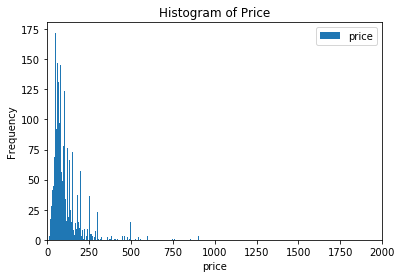

In [109]:
ax = mycity_df.select('price').toPandas().plot(kind='hist', bins=500)
ax.set_xlim([0, 3000])
ax.set_xlabel('price')
ax.set_title('Histogram of Price')

The value of a listing is its rating divided by its price.

In [111]:
mycity_w_value = mycity_df.withColumn('value', f.round(f.col('review_scores_rating')/f.col('price'), 2))

Compute and show a dataframe with the 3 highest valued listings in each neighbourhood.

-  with a window function we basically treat each group as a separate dataframe. for each neighbourhood we list in decreasing value the listings and we store them in the window function.
-  then we add a new column in the orginal df with the values from the values_widonw(df) 
- finally we filter the values with ValueRank < 3, taking some columns of the df and sorting in decreasing order of value

In [113]:
values_window = Window.partitionBy('neighbourhood').orderBy(f.desc('value'))

ranked_values = mycity_w_value.withColumn('ValueRank', f.rank().over(values_window))
ranked_values.filter(f.col('ValueRank') <= 3)\
    .select('id', 'neighbourhood', 'review_scores_rating', 'price', 'value')\
    .orderBy('neighbourhood', f.desc('value'))\
    .show()

+--------+-------------+--------------------+-----+-----+
|      id|neighbourhood|review_scores_rating|price|value|
+--------+-------------+--------------------+-----+-----+
| 2657825|       Affori|                  97| 35.0| 2.77|
| 2739325|       Affori|                  92|250.0| 0.37|
| 2400202|       Affori|                null|100.0| null|
| 2783727|       Baggio|                 100| 40.0|  2.5|
|  779841|       Baggio|                  82| 89.0| 0.92|
|26406985|       Baggio|                 100|198.0| 0.51|
| 3083570|       Barona|                  92| 38.0| 2.42|
|  667264|       Barona|                  93| 39.0| 2.38|
| 4350320|       Barona|                  80| 35.0| 2.29|
| 3161334|       Bovisa|                  93| 16.0| 5.81|
|  737797|       Bovisa|                  99| 21.0| 4.71|
| 9573933|       Bovisa|                  66| 18.0| 3.67|
| 1703576|    Bovisasca|                  94| 30.0| 3.13|
| 4254200|        Brera|                  96| 62.0| 1.55|
| 4337304|    

## Trends
Now we want to analyze the "popularity" of your city. The data does not contain the number of bookings per listing, but we have a large number of reviews, and we will assume that this is a good indicator of activity on listings.

In [115]:
df_reviews.printSchema()

root
 |-- listing_id: string (nullable = true)
 |-- id: string (nullable = true)
 |-- date: string (nullable = true)
 |-- reviewer_id: string (nullable = true)
 |-- reviewer_name: string (nullable = true)
 |-- comments: string (nullable = true)



In [117]:
disp(df_reviews, 10)

,listing_id,id,date,reviewer_id,reviewer_name,comments
0,145320,156423122,2017-05-30,123386382,Erwin,Prima plek om Stockholm te bekijken. Alles is ...
1,145320,170211906,2017-07-15,123091743,Anne,Cosy and clean flat in quiet neighbourhood clo...
2,145320,172169175,2017-07-20,78004,Patricia,The host canceled this reservation 37 days bef...
3,145320,176647581,2017-07-31,103178743,Charlotte,Kim's place was outstanding and comfortable. W...
4,145320,185676021,2017-08-22,4023961,Alexander,great spacious apartment in a nice residential...
5,145320,189668224,2017-09-02,142869362,Heiko,Kim is a very friendly person.A lot of advice ...
6,145320,191894030,2017-09-09,25194419,Jason,The apartment is cost and Kim was a terrific h...
7,145320,193316070,2017-09-13,52056015,David,"Nicely appointed, in a great location, with a ..."
8,145320,196760607,2017-09-24,3980456,Janne,It was a pleasure staying at Kim’s apartment i...
9,145320,201885633,2017-10-09,72139946,Florence,"Kim's place is simply amazing, it was such a c..."


We want to join the listing_df and the review_df on the listing_id and id. 

In [119]:
mycity_review = mycity_df.select('neighbourhood', 'property_type', f.col('id').alias('id_'))\
    .join(df_reviews, (df_reviews.listing_id == f.col('id_')), 'inner')\
    .drop('id_')

In [136]:
mycity_review.limit(10).toPandas()

,neighbourhood,property_type,listing_id,id,date,reviewer_id,reviewer_name,comments
0,Città Studi,Apartment,1680685,13048057,2014-05-18,14851795,Francesca,La mia esperienza da Costanza è stata ottima.\...
1,Città Studi,Apartment,1680685,13321021,2014-05-25,8280853,Kseniya,Costanza is a good and responsive host!\r\nApa...
2,Città Studi,Apartment,1680685,14500188,2014-06-21,13034533,Fede,The reservation was canceled 9 days before arr...
3,Città Studi,Apartment,1680685,18832023,2014-09-01,19965087,Claudia,Una casa calda e accogliente è raro trovarla m...
4,Città Studi,Apartment,1680685,23779550,2014-12-09,18961641,Caterina,Costanza ha sido muy amable y nos ha ayudado c...
5,Città Studi,Apartment,1680685,24243690,2014-12-23,23884894,Carlo,Costanza è stata una host gentile e disponibil...
6,Città Studi,Apartment,1680685,24958163,2015-01-04,24405727,Danielle,Costanza is a very nice host. She arranged for...
7,Città Studi,Apartment,1680685,28566032,2015-03-26,28014638,Angelo,"Si tratta di un appartamento comodo, carino, m..."
8,Città Studi,Apartment,1680685,30196054,2015-04-19,22814177,Valeria,Consiglio a tutti l`appartamento di Costanza:s...
9,Città Studi,Apartment,1680685,33572717,2015-05-30,11682903,Dong Qyu (David),"I stayed at Costanza's place for 6 weeks, and ..."


## why we carried on the property types? also we can get rid of many columns...

In [138]:
columns_to_drop = ['property_type','reviewer_id','reviewer_id']
mycity_review_clean  = mycity_review.drop(*columns_to_drop)

# mycity_review_clean <-----------------------------------------------------------

In [139]:
mycity_review_clean.limit(10).toPandas()

,neighbourhood,listing_id,id,date,reviewer_name,comments
0,Città Studi,1680685,13048057,2014-05-18,Francesca,La mia esperienza da Costanza è stata ottima.\...
1,Città Studi,1680685,13321021,2014-05-25,Kseniya,Costanza is a good and responsive host!\r\nApa...
2,Città Studi,1680685,14500188,2014-06-21,Fede,The reservation was canceled 9 days before arr...
3,Città Studi,1680685,18832023,2014-09-01,Claudia,Una casa calda e accogliente è raro trovarla m...
4,Città Studi,1680685,23779550,2014-12-09,Caterina,Costanza ha sido muy amable y nos ha ayudado c...
5,Città Studi,1680685,24243690,2014-12-23,Carlo,Costanza è stata una host gentile e disponibil...
6,Città Studi,1680685,24958163,2015-01-04,Danielle,Costanza is a very nice host. She arranged for...
7,Città Studi,1680685,28566032,2015-03-26,Angelo,"Si tratta di un appartamento comodo, carino, m..."
8,Città Studi,1680685,30196054,2015-04-19,Valeria,Consiglio a tutti l`appartamento di Costanza:s...
9,Città Studi,1680685,33572717,2015-05-30,Dong Qyu (David),"I stayed at Costanza's place for 6 weeks, and ..."


### - Compute and visualize the popularity (i.e., number of reviews) of your city over time.

mycity_1 = mycity_df.groupBy('neighbourhood','property_type')\
    .agg(f.count('property_type').alias('property_type_per_neighbourhood'))\
    .select('neighbourhood','property_type', 'property_type_per_neighbourhood')\
    .sort(f.desc("neighbourhood"), f.desc("property_type"))

In [135]:
mycity_pop_by_year = mycity_review.groupby(f.year('date').alias('year'))\
                        .count()

AttributeError: 'GroupedData' object has no attribute 'sort'

In [144]:
disp(mycity_pop_by_year, n=10)

KeyboardInterrupt: 

## how to sort a GroupedData object?

mycity_pop_by_year
AttributeError: 'GroupedData' object has no attribute 'sort'

In [134]:
ax = mycity_review('count').plot(kind='hist', bins=500)
ax.set_xlim([0, 3000])
ax.set_xlabel('years')
ax.set_title('Histogram of City Popularity per year')

TypeError: 'DataFrame' object is not callable

## how to plot count(y) vs year(x)

### - Compute and visualize the popularity of neighbourhoods over time. 

If there are many neighbourhoods in your city, you should select a few interesting ones for comparison.

values_window = Window.partitionBy('neighbourhood').orderBy(f.desc('value'))
ranked_values = mycity_w_value.withColumn('ValueRank', f.rank().over(values_window))
ranked_values.filter(f.col('ValueRank') <= 3)\
    .select('id', 'neighbourhood', 'review_scores_rating', 'price', 'value')\
    .orderBy('neighbourhood', f.desc('value'))\
    .show()

In [131]:
myneigh_pop_by_year  = mycity_review.groupby('neighbourhood',f.year('date'))\
                    .count()

In [132]:
myneigh_pop_by_year.show()

+------------------+----------+-----+
|     neighbourhood|year(date)|count|
+------------------+----------+-----+
|            Zona 2|      2012|  108|
|    Centro Storico|      2014| 2104|
|            Zona 7|      2015|  819|
|            Zona 2|      2016| 1807|
|            Affori|      2016|   18|
|            Zona 6|      2012|  103|
|            Zona 9|      2014|  695|
|             Brera|      2019|  157|
|            Zona 8|      2015| 1345|
|            Zona 7|      2011|   27|
|             Brera|      2016|  262|
|       Città Studi|      2016|  404|
|            Zona 9|      2016| 1099|
|      Porta Romana|      2015|  330|
|Centro Direzionale|      2014|  408|
|            Zona 2|      2019| 1329|
|            Zona 2|      2014| 1040|
|            Zona 8|      2018|  911|
|         Chinatown|      2019|   89|
|            Zona 4|      2014|  401|
+------------------+----------+-----+
only showing top 20 rows



### - Compute and visualize the popularity of your city by season. 
For example, visualize the popularity of your city per month.

In [140]:
mycity_pop_by_season = mycity_review.groupby(f.year('date'),f.month('date')).count()

In [141]:
mycity_pop_by_season.show()

+----------+-----------+-----+
|year(date)|month(date)|count|
+----------+-----------+-----+
|      2012|         10|  181|
|      2010|         12|    1|
|      2010|          7|    1|
|      2015|          2|  911|
|      2017|          3| 1116|
|      2017|          8| 1056|
|      2014|          4| 1092|
|      2019|          5| 1571|
|      2018|         10| 1610|
|      2017|         10| 1738|
|      2016|          7| 1482|
|      2015|         12|  816|
|      2016|         11| 1217|
|      2019|          3| 1231|
|      2013|          2|  127|
|      2012|          8|   55|
|      2012|         12|  107|
|      2012|          4|  148|
|      2018|          1| 1143|
|      2018|          3| 1334|
+----------+-----------+-----+
only showing top 20 rows



## Reviews
In this part you should determine which words used in reviews that are the most positive. 

The individual reviews do not have a rating of the listing, so we will assume that each review gave the average rating to the listing, i.e., the one on the listing.

You should assign a positivity weight to each word seen in reviews and list the words with the highest weight. It is up to you to decide what the weight should be. For example, it can be a function of the rating on the listing on which it occurs, the number of reviews it occurs in, and the number of unique listings for which it was used to review.

Depending on your choice of weight function, you may also want to do some filtering of words. For example, remove words that only occur in a few reviews.

###### ideas
- "The individual reviews do not have a rating of the listing" ---> there fore we use review_scores_rating is actually a rating of eachthe listing for each individual review 

- my impression is that they dont ask to apply a pre trained NLP model (we pour all the words all together and they come out of the model in vectors with meaning), but that we follow their indications.


- df1 = mycity_review_clean
- df2 = mycity_df
- join df1 and df2 on "id" column. careful with df1, has many id-ish columns.

- natural language processing task, tool? 
    - Natural Language Toolkit(NLTK)?

- we want to sort of count or estimate frequencies of words
- we want to focus on the most frequent and rapresentative words of the reviews
- we want a score of positivity or negativity for each word and the overall review score is given by the sum of the scores of the words
- rare words should have an higher score (one doesnt use flabbergasting as much as good)
- more frequent words should have an higher score? nah maybe not
- we can assume longer review have more significative words


###### what? 
1- LIST_OF_RAPRESENTATIVE_WORDS (n =40); COUNT_TOT_IN_NEG_REVIEWS; COUNT_TOT_IN_POS_REVIEWS; COUNT_TOT ; 
    - 1)"Good"; 10, 80, 90
    - ....
    - 40)"Disgusting"; 30, 10, 40
 

2-RARE if COUNT_TOT< 0.5*COUNT_AVERAGE
    - "Good" not RARE    r = 1
    - "Disgusting" RARE  r = 1.5

3 - get the weights for each rapresentative word: 
    - eg .WEIGHT = P * review_scores_rating/100 *r
    - P = (1,-1) # Positive or negative
    - review_scores_rating = [0,1] # 85,32 etc 
    - r = 1 or 1.5 # rarity factor
    
    
4 - example
    - word ; WEIGHT 
    - 1)"Good"; 0.75
    - 2)"OK"; 0.6
    - 3)"flabbergasting";0.95
    - ....
    - 40)"Disgusting"; -0.80



###### how? 

1-LIST_OF_RAPRESENTATIVE_WORDS (n =40)
- we take all the reviews and trasform them in bag of words, tokenization
- we output the 10-20 most frequent words overall
    we expect them to be non useful fillers ('the', 'end', 'but', 'a', 'an', 'not' etc)
    NOTE: stripping not can create problems... but expressions like "not good" will be most likely missinterpreted

- we threshold reviews 
    - review_scores_rating > 60 review_score =(1) POSITIVE
    - review_scores_rating < 60 review_score =(0) NEGATIVE

- we take only the positive reviews and trasform them in bag of words, tokenization
- we output the 40-60 most frequent words overall, so we keep their counting, those we expect to be the fillers and the most rapresentative words (great, beautiful etc) 
    - we make the difference and we get LIST_OF_RAPRESENTATIVE_WORDS_POSITIVE
- we repeat the same for the negative reviews, we get the LIST_OF_RAPRESENTATIVE_WORDS_NEGATIVE
- then its done

In [ ]:
## join the two df

In [149]:
A_reviews = mycity_review_clean
A_listings = mycity_df

reviews_scores = A_listings.select('review_scores_rating', 'id').join(A_reviews, A_listings.id == A_reviews.listing_id)

In [151]:
#disp(reviews_scores, n=10)
reviews_scores.printSchema()

root
 |-- review_scores_rating: string (nullable = true)
 |-- id: string (nullable = true)
 |-- neighbourhood: string (nullable = true)
 |-- listing_id: string (nullable = true)
 |-- id: string (nullable = true)
 |-- date: string (nullable = true)
 |-- reviewer_name: string (nullable = true)
 |-- comments: string (nullable = true)



In [171]:
from pyspark.ml.feature import Tokenizer
from pyspark.ml.feature import StopWordsRemover

tokenizer = Tokenizer(inputCol="comments", outputCol="words") 
tokenized = tokenizer.transform(reviews_scores)
remover = StopWordsRemover(inputCol="words", outputCol="filtered_words")
filtered = remover.transform(tokenized)

In [173]:
reviews_scores.printSchema()

root
 |-- review_scores_rating: string (nullable = true)
 |-- id: string (nullable = true)
 |-- neighbourhood: string (nullable = true)
 |-- listing_id: string (nullable = true)
 |-- id: string (nullable = true)
 |-- date: string (nullable = true)
 |-- reviewer_name: string (nullable = true)
 |-- comments: string (nullable = true)
 |-- bag_of_words: string (nullable = true)



In [174]:
tokenized.printSchema()

root
 |-- review_scores_rating: string (nullable = true)
 |-- id: string (nullable = true)
 |-- neighbourhood: string (nullable = true)
 |-- listing_id: string (nullable = true)
 |-- id: string (nullable = true)
 |-- date: string (nullable = true)
 |-- reviewer_name: string (nullable = true)
 |-- comments: string (nullable = true)
 |-- bag_of_words: string (nullable = true)
 |-- words: array (nullable = true)
 |    |-- element: string (containsNull = true)



In [176]:
filtered.printSchema()

root
 |-- review_scores_rating: string (nullable = true)
 |-- id: string (nullable = true)
 |-- neighbourhood: string (nullable = true)
 |-- listing_id: string (nullable = true)
 |-- id: string (nullable = true)
 |-- date: string (nullable = true)
 |-- reviewer_name: string (nullable = true)
 |-- comments: string (nullable = true)
 |-- bag_of_words: string (nullable = true)
 |-- words: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- filtered_words: array (nullable = true)
 |    |-- element: string (containsNull = true)



In [ ]:
filtered.show().take(5)

In [ ]:
filtered.limit(5).toPandas()

In [156]:
def get_words_from_review(reviews):
    tokenizer = Tokenizer(inputCol="comments", outputCol="bag_of_words")
    tokenized = tokenizer.transform(reviews_scores)
    remover = StopWordsRemover(inputCol="words", outputCol="filtered_words"
    return (tokenized,remover) 

In [155]:
from pyspark.sql.functions import lit
reviews_scores = reviews_scores.withColumn("bag_of_words", lit(None).cast(StringType()))

In [ ]:
from pyspark.sql.functions import lit
reviews_scores = reviews_scores.withColumn("bag_of_words", get_words_from_review("reviews").cast(StringType()))